# Ejercicios

In [ ]:
import numpy as np
import pandas as pd
import itertools
import warnings
import matplotlib.pyplot as plt
from scipy.stats import boxcox
import statsmodels.formula.api as smf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [ ]:
actual_options = dict(color="C0", lw=1, alpha=1.0)
trend_options = dict(color="C1", alpha=1.0)
pred_options = dict(color="C2", lw=2.0 , alpha=1.0, ls=':')
model_options = dict(color="gray", lw=1.5, alpha=1.0, ls='--')

## Ejercicio 1

Como ejemplo de **descomposición estacional**, modelemos las temperaturas medias mensuales en superficie en Estados Unidos.

Utilizaremos un conjunto de datos de `Our World in Data` que incluye "la temperatura (en grados Celsius) del aire medida a 2 metros sobre el suelo, incluyendo tierra, mar y superficies de agua continentales" para la mayoría de los países del mundo desde 1950 hasta 2024.

In [ ]:
# La siguiente celda descarga datos preparados por Our World in Data, hasta el 18 de septiembre de 2024
# de https://ourworldindata.org/grapher/average-monthly-surface-temperature

# Basado en datos modificados de la información del Servicio de Cambio Climático de Copernicus (2019)
# con "major processing" por 'Our World in Data'

In [ ]:
path = "https://github.com/AllenDowney/ThinkStats/raw/v3/data/monthly-average-surface-temperatures-by-year.csv"

Podemos leer los datos de esta manera.

In [ ]:
temp = pd.read_csv(path)

In [ ]:
temp.head()

,Entity,Code,Year,2024,2023,2022,2021,2020,2019,2018,...,1959,1958,1956,1954,1952,1957,1955,1953,1951,1950
0,Afghanistan,AFG,1,3.300064,-4.335608,-0.322859,-1.001608,-2.560545,0.585145,1.042471,...,-2.333814,0.576404,-3.351925,-2.276692,-2.812619,-4.239172,-2.191683,-2.915993,-3.126317,-2.655707
1,Afghanistan,AFG,2,1.024550,4.187041,2.165870,5.688000,2.880046,0.068664,3.622793,...,-1.545529,0.264962,0.455350,-0.304205,0.798226,-2.747945,1.999074,1.983414,-2.642800,-3.996040
2,Afghanistan,AFG,3,5.843506,10.105444,10.483686,9.777976,6.916731,5.758049,10.794412,...,5.942937,7.716459,5.090270,4.357703,4.796146,4.434027,7.066073,4.590406,3.054388,3.491112
3,Afghanistan,AFG,4,11.627398,14.277164,17.227650,15.168276,12.686832,13.838840,14.321226,...,13.752827,14.712909,11.982360,12.155265,13.119270,8.263829,10.418768,11.087193,9.682878,8.332797
4,Afghanistan,AFG,5,18.957850,19.078170,19.962734,19.885902,18.884047,18.461287,18.100782,...,17.388723,16.352045,20.125462,18.432117,17.614851,15.505956,15.599709,17.865084,17.095737,17.329062


La siguiente celda selecciona los datos de Estados Unidos desde 2001 hasta el final de la serie y los empaqueta en una `Serie` de `Pandas`.

In [ ]:
temp_us = temp.query("Code == 'USA'")
columns = [str(year) for year in range(2000, 2025)]

temp_series = temp_us.loc[:, columns].transpose().stack()

temp_series.index = pd.date_range(start="2000-01", periods=len(temp_series), freq="ME")

Así es como se ve.

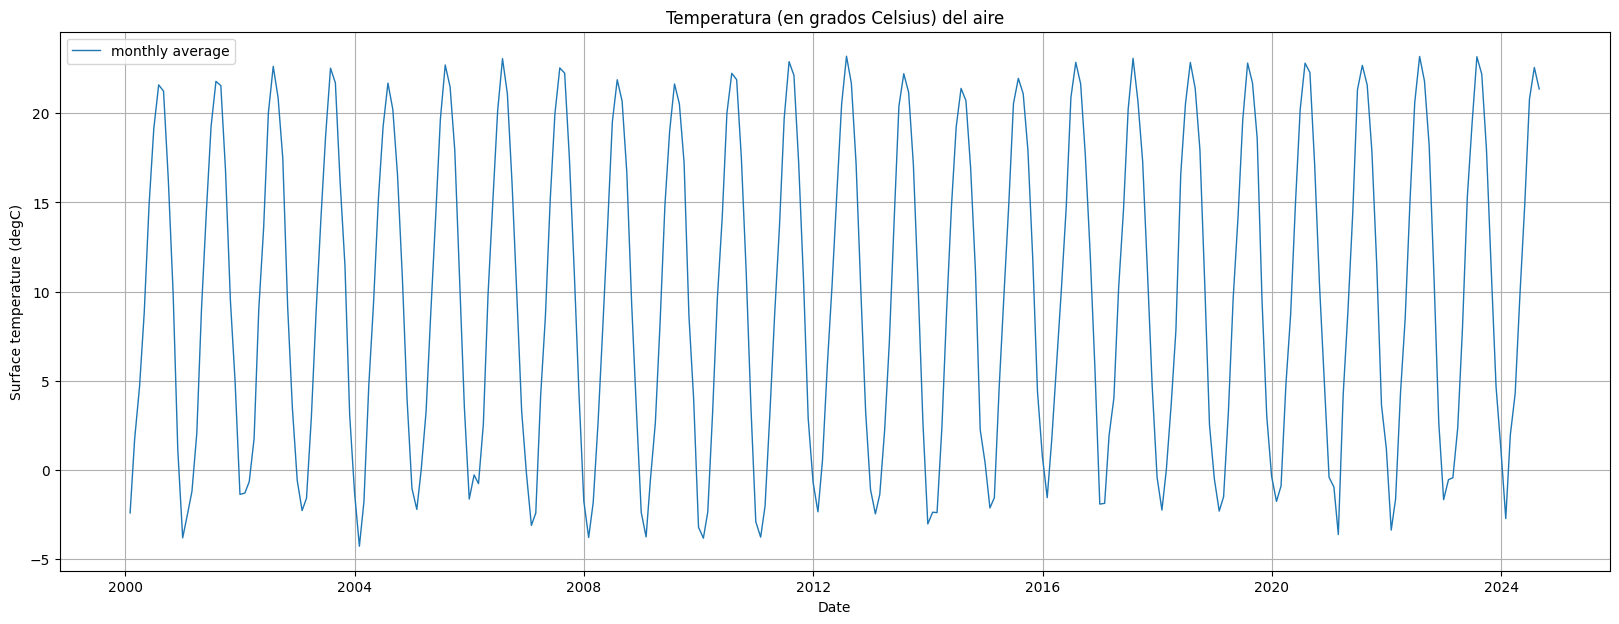

In [ ]:
#Plot
plt.figure(figsize=(20, 7))

plt.plot(temp_series, label="monthly average", **actual_options)

plt.title('Temperatura (en grados Celsius) del aire')
plt.ylabel('Surface temperature (degC)')
plt.xlabel('Date')
plt.legend()
plt.grid()
plt.show()

Como era de esperar, existe un marcado patrón estacional.

* Calcule una **descomposición estacional** utilizando un período de `12 meses`.

***NOTA.***
`Solo para este primer ejercicio, no utilice ninguna libreria para hacer la descomposicion, realiza la descomposicion manualmente tal como se vio en clase.`

**Hint.**`.rolling()`



* Ajuste un **modelo ols** a la línea de tendencia.

* Descubra si se trata de una composicion aditiva o multiplicativa y utilice la tendencia y el componente estacional para recrear la serie temporal original.

* Muestre el componente residual.

In [ ]:
trend = temp_series.rolling(window=12, center=True).mean()
trend


,0
2000-01-31,NaN
2000-02-29,NaN
2000-03-31,NaN
2000-04-30,NaN
2000-05-31,NaN
...,...
2024-04-30,NaN
2024-05-31,NaN
2024-06-30,NaN
2024-07-31,NaN


In [ ]:
detrended = temp_series - trend
monthly = detrended.groupby(temp_series.index.month).mean()
seasonal = temp_series.index.to_series().apply(lambda d: monthly[d.month])
seasonal


,0
2000-01-31,-12.238267
2000-02-29,-10.768916
2000-03-31,-6.277779
2000-04-30,-0.858457
2000-05-31,4.858971
...,...
2024-04-30,-0.858457
2024-05-31,4.858971
2024-06-30,10.121265
2024-07-31,12.649114


In [ ]:
residual = temp_series - trend - seasonal
residual


,0
2000-01-31,NaN
2000-02-29,NaN
2000-03-31,NaN
2000-04-30,NaN
2000-05-31,NaN
...,...
2024-04-30,NaN
2024-05-31,NaN
2024-06-30,NaN
2024-07-31,NaN


In [ ]:
t = pd.Series(range(len(trend)), index=trend.index)
df_trend = pd.DataFrame({"y": trend, "t": t})
model = smf.ols("y ~ t", data=df_trend).fit()
model.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.339
Model:                            OLS   Adj. R-squared:                  0.336
Method:                 Least Squares   F-statistic:                     145.0
Date:                Thu, 20 Nov 2025   Prob (F-statistic):           3.06e-27
Time:                        22:33:36   Log-Likelihood:                -137.08
No. Observations:                 285   AIC:                             278.2
Df Residuals:                     283   BIC:                             285.5
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      9.3216      0.048    194.650      0.000       9.227       9.416
t              0.0034      0.000     12.042      0.000       0.003       0.004
==============================================================================
Omnibus:                        3.340   Durbin-Watson:                   0.068
Prob(Omnibus):                  0.188   Jarque-Bera (JB):                3.049
Skew:                           0.180   Prob(JB):                        0.218
Kurtosis:                       2.644   Cond. No.                         349.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

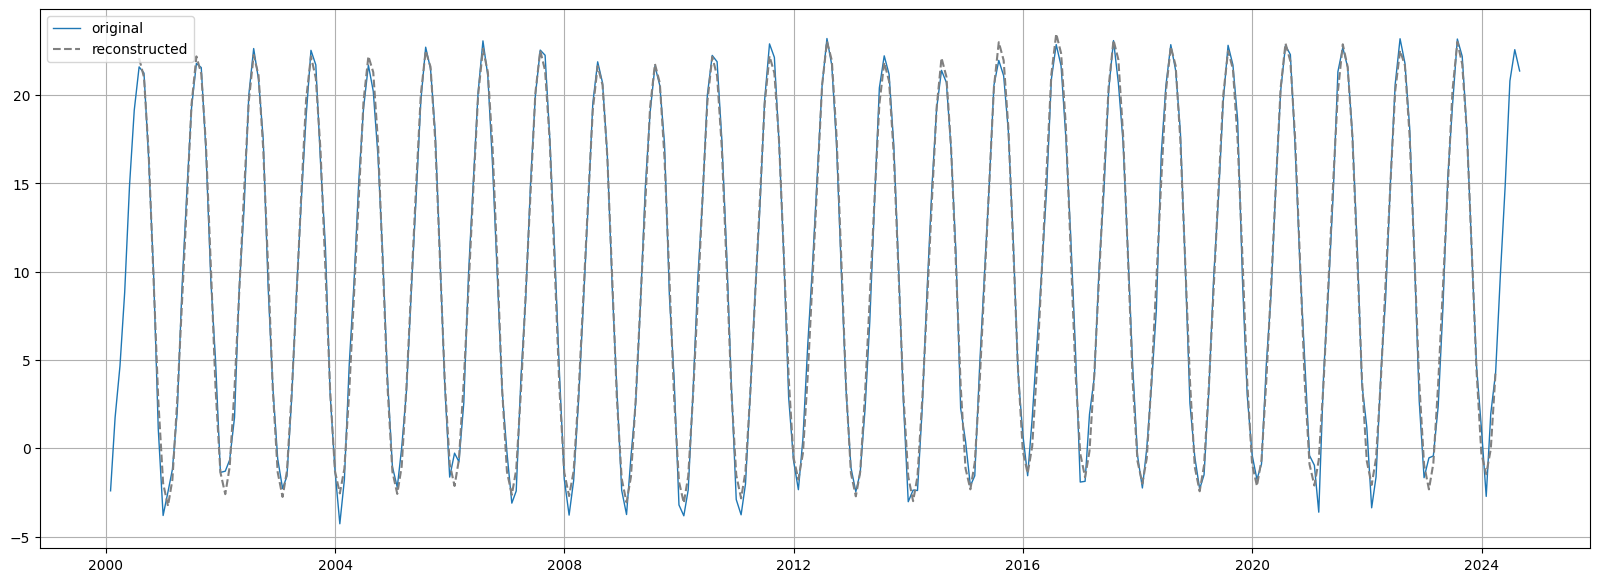

In [ ]:
reconstructed = trend + seasonal
plt.figure(figsize=(20,7))
plt.plot(temp_series, **actual_options, label="original")
plt.plot(reconstructed, **model_options, label="reconstructed")
plt.legend()
plt.grid()
plt.show()


* **¿Cuál es el aumento medio anual de la temperatura superficial durante este intervalo?**

A partir del coeficiente del modelo OLS (0.0034 °C por mes), el aumento medio anual de la temperatura superficial es aproximadamente 0.041 °C por año durante el intervalo analizado.



## Ejercicio 2

Anteriormente, utilizamos una descomposición estacional multiplicativa para modelar la producción de electricidad a partir de energía solar a pequeña escala entre 2014 y 2019, y pronosticar la producción entre 2019 y 2024.

Ahora hagamos lo mismo con la energía solar a escala industrial.

In [ ]:
path = "https://raw.githubusercontent.com/AllenDowney/ThinkStats/refs/heads/v3/data/Net_generation_for_all_sectors.csv"

elec = (pd.read_csv(path, skiprows=4).drop(columns=["units", "source key"]) # Eliminar columnas "units" y "source key"
                                     .set_index("description") #Designamos la fila "description", que contiene las fechas, como indice del DataFrame
                                     .replace("--", np.nan) # Reemplazamos los valores "--" como valores NaN
                                     .transpose() # Al ser una tabla Horizontal, convertimos las filas (Features) en columnas
                                     .astype(float))

# reemplazamos los indices strings con objetos Timestamp de Pandas.
elec.index = pd.date_range(start="2001-01", periods=len(elec), freq="ME")

In [ ]:
util_solar = elec["United States : all utility-scale solar"].dropna()

util_solar = util_solar[util_solar.index.year >= 2014]

Así es como se ve la serie temporal.

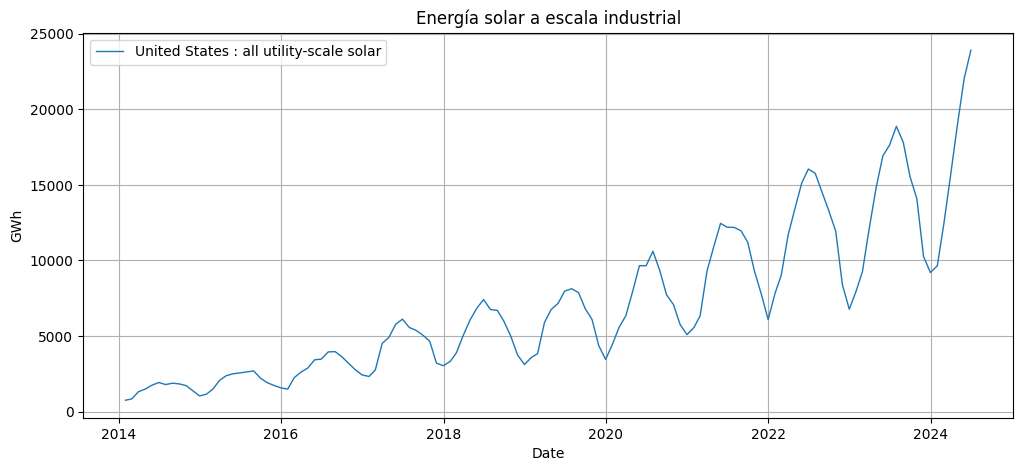

In [ ]:
#Plot
plt.figure(figsize=(12, 5))

plt.plot(util_solar, label="United States : all utility-scale solar", **actual_options)

plt.title('Energía solar a escala industrial')
plt.ylabel('GWh')
plt.xlabel('Date')
plt.legend()
plt.grid()
plt.show()

Utilice `split_series` para dividir estos datos en una serie de entrenamiento y una serie de prueba.

In [ ]:
def split_series(series, n=60):
    training = series.iloc[:-n]
    test = series.iloc[-n:]
    return training, test

* Calcule una **descomposición**, averigue si multiplicativa o aditiva, de la serie de entrenamiento con un período de `12 meses`.

* Ajuste un `modelo ols` que mejor se ajuste a la tendencia (**trend**), es decir, lineal, cuadrático, etc. Muestre los resultados del modelo (`summary()`) para ver que tal bien el modelo se ajusto.

* Genere una previsión a `5 años`, incluyendo un componente estacional.

In [ ]:
train, test = split_series(util_solar, n=60)


In [ ]:
trend = train.rolling(window=12, center=True).mean()
detrended = train / trend
monthly = detrended.groupby(train.index.month).mean()
seasonal = train.index.to_series().apply(lambda d: monthly[d.month])


In [ ]:
t = pd.Series(range(len(trend)), index=trend.index)
df_trend = pd.DataFrame({"y": trend, "t": t})
df_trend["t2"] = df_trend["t"]**2

model = smf.ols("y ~ t + t2", data=df_trend).fit()
model.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.981
Model:                            OLS   Adj. R-squared:                  0.980
Method:                 Least Squares   F-statistic:                     1324.
Date:                Thu, 20 Nov 2025   Prob (F-statistic):           2.52e-45
Time:                        22:55:54   Log-Likelihood:                -367.02
No. Observations:                  55   AIC:                             740.0
Df Residuals:                      52   BIC:                             746.1
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    820.1681    116.060      7.067      0.000     587.276    1053.060
t             72.4718      7.953      9.113      0.000      56.514      88.430
t2             0.2046      0.118      1.737      0.088      -0.032       0.441
==============================================================================
Omnibus:                       40.773   Durbin-Watson:                   0.059
Prob(Omnibus):                  0.000   Jarque-Bera (JB):                5.113
Skew:                          -0.174   Prob(JB):                       0.0776
Kurtosis:                       1.547   Cond. No.                     7.52e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 7.52e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [ ]:
future_t = pd.Series(range(len(t), len(t) + 60))
future_df = pd.DataFrame({"t": future_t})
future_df["t2"] = future_df["t"]**2

trend_future = model.predict(future_df)
seasonal_future = np.tile(monthly.values, 5)

forecast = trend_future * seasonal_future
forecast = pd.Series(forecast, index=test.index)


* Trazar la previsión junto con la serie de prueba (**test**) y calcular el error porcentual absoluto medio (**MAPE**).

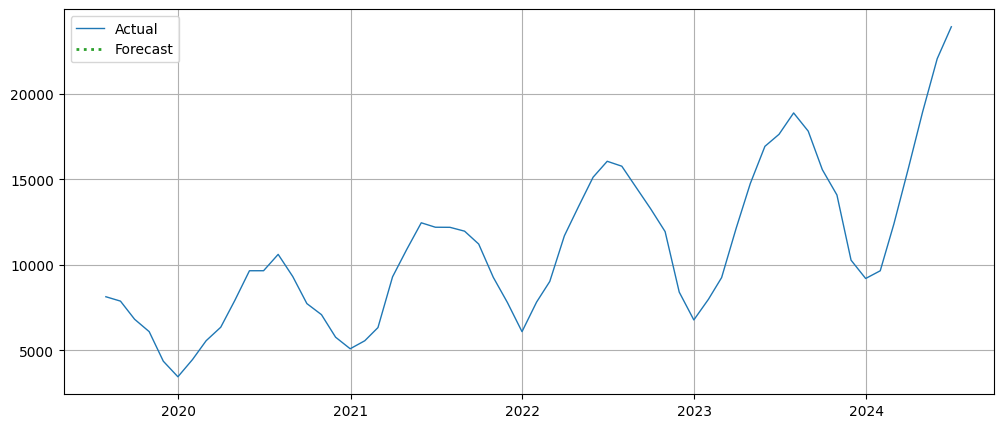

In [ ]:
plt.figure(figsize=(12,5))
plt.plot(test, label="Actual", **actual_options)
plt.plot(forecast, label="Forecast", **pred_options)
plt.legend()
plt.grid()
plt.show()


In [ ]:
MAPE_nozero(forecast, test)


nan

In [ ]:
def MAPE(predicted, actual):
    Mape = np.abs((actual - predicted) / actual)
    return np.mean(Mape) * 100

In [ ]:
def MAPE_nozero(predicted, actual):
    mask = actual != 0
    return np.mean(np.abs((actual[mask] - predicted[mask]) / actual[mask])) * 100


## Ejercicio 3

Veamos qué tan bien se ajusta un **modelo ARIMA** a la producción de los generadores hidroeléctricos en los Estados Unidos.

Así es como se ve la serie temporal de 2001 a 2024.

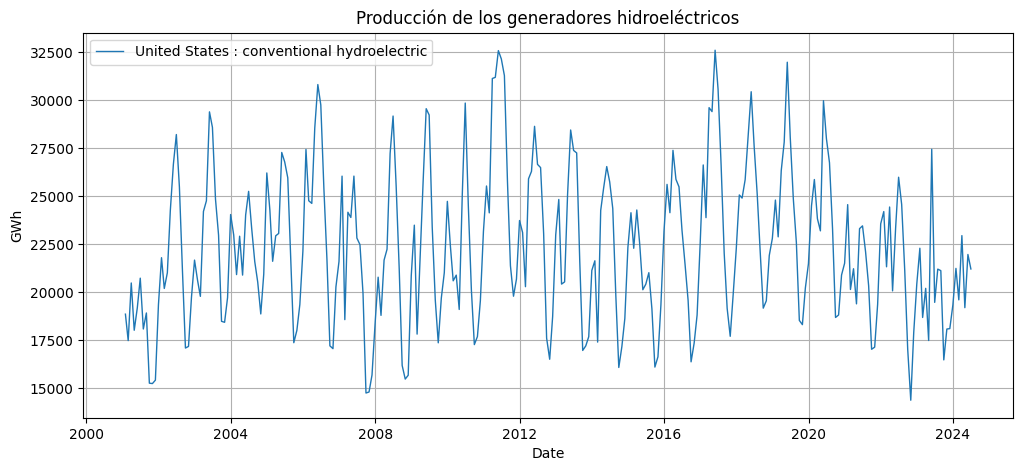

In [ ]:
hydro = elec["United States : conventional hydroelectric"]

#Plot
plt.figure(figsize=(12, 5))

plt.plot(hydro, label="United States : conventional hydroelectric", **actual_options)

plt.title('Producción de los generadores hidroeléctricos')
plt.ylabel('GWh')
plt.xlabel('Date')
plt.legend()
plt.grid()
plt.show()

Ajuste un **modelo SARIMA** a estos datos con un período estacional de `12 meses`.

* Verifique que la serie cumpla con estacionariedad de media y varianza. De ser necesario, aplique **transformacion (varianza)** y **eliminacion de tendencia** para mejorar el desempeño (*Recuerde aplicar las transformaciones inversas en las predicciones*).

* Asegurese que la serie temporal es estacionaria usando el **test Dickey-Fuller**.

* Haga uso de graficos **ACF** y **PACF** como guia para encontrar los parametros adecuados.

* Experimente con diferentes retrasos (`lags`) en las partes de **autorregresión** y **media móvil** del modelo y vea si puede encontrar una combinación que maximice el valor $R^2$ o minimice el valor $BIC$/$AIC$ del modelo.

*NOTA:* Dependiendo de los `lags` que incluya en el modelo, es posible que los primeros 12 a 24 elementos de los valores ajustados no sean confiables. Es posible que desee eliminarlos antes de graficarlos o calcular $R^2$.

In [ ]:
hydro_log = np.log(hydro)

train, test = split_series(hydro, n=60)
train_log, test_log = split_series(hydro_log, n=60)

diff1 = train_log.diff().dropna()
diff_seasonal = diff1.diff(12).dropna()

adf_result = adfuller(diff_seasonal)
adf_result[1]


np.float64(2.0962323734914572e-10)

<Figure size 1200x400 with 0 Axes>

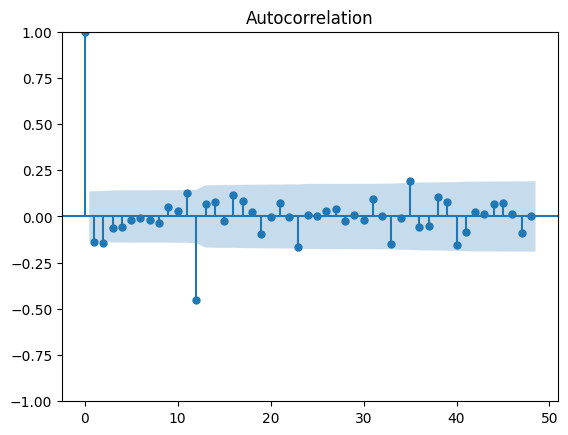

<Figure size 1200x400 with 0 Axes>

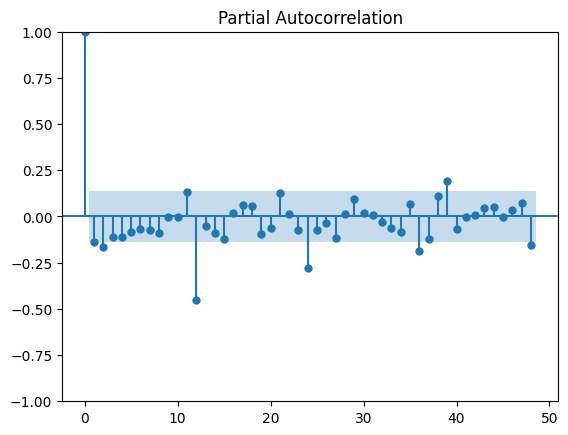

In [ ]:
plt.figure(figsize=(12,4))
plot_acf(diff_seasonal, lags=48)
plt.show()

plt.figure(figsize=(12,4))
plot_pacf(diff_seasonal, lags=48)
plt.show()


In [ ]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

sarima_model = SARIMAX(train_log, order=(1,1,1), seasonal_order=(1,1,1,12),
                       enforce_stationarity=False, enforce_invertibility=False)
sarima_res = sarima_model.fit()
sarima_res.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                                           SARIMAX Results                                            
======================================================================================================
Dep. Variable:     United States : conventional hydroelectric   No. Observations:                  222
Model:                         SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood                 226.016
Date:                                        Thu, 20 Nov 2025   AIC                           -442.032
Time:                                                23:09:52   BIC                           -425.667
Sample:                                            01-31-2001   HQIC                          -435.406
                                                 - 06-30-2019                                         
Covariance Type:                                          opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7297      0.064     11.484      0.000       0.605       0.854
ma.L1         -0.9998      5.173     -0.193      0.847     -11.139       9.139
ar.S.L12    6.642e-05   6.24e-05      1.064      0.287    -5.6e-05       0.000
ma.S.L12      -0.9966      1.981     -0.503      0.615      -4.880       2.887
sigma2         0.0049      0.026      0.189      0.850      -0.045       0.055
===================================================================================
Ljung-Box (L1) (Q):                   0.07   Jarque-Bera (JB):                 3.06
Prob(Q):                              0.79   Prob(JB):                         0.22
Heteroskedasticity (H):               0.92   Skew:                            -0.09
Prob(H) (two-sided):                  0.73   Kurtosis:                         3.59
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

* Muestre el grafico de desempeño (`plot_diagnostics`)

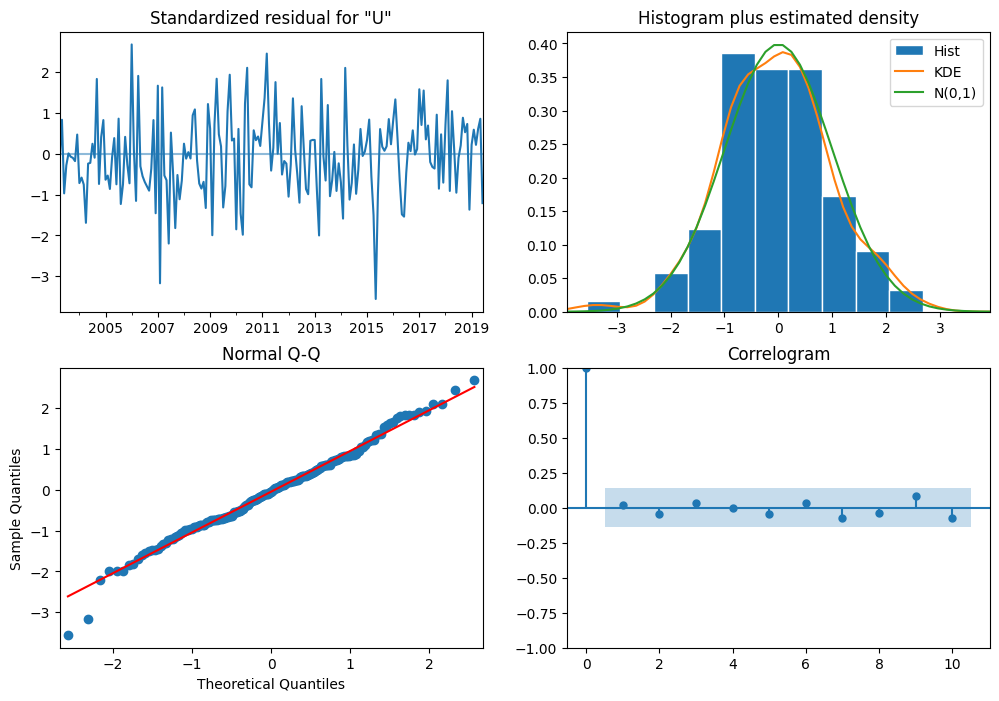

In [ ]:
sarima_res.plot_diagnostics(figsize=(12,8))
plt.show()


**Basado en la informacion mostrada en los graficos, ¿Qué podemos concluir de nuestro modelo?**

En general, los diagnósticos indican que el modelo SARIMA se ajusta razonablemente bien a la serie. Los residuales tienen media cercana a cero, no muestran patrones claros de autocorrelación y su varianza es aproximadamente constante en el tiempo. El gráfico Q–Q sugiere que la distribución de los errores se aproxima a la normal, con algunas desviaciones solo en valores extremos. Por lo tanto, el modelo captura adecuadamente la estructura temporal principal de la serie, aunque pueden existir algunos eventos atípicos que no quedan totalmente explicados.



* Genere un pronóstico de `5 años` y grafiquelos junto con su **intervalo de confianza**.

* Para cuantificar la precisión de las predicciones, utilice el **error porcentual absoluto medio** (`MAPE`).

In [ ]:
pred = sarima_res.get_forecast(steps=len(test_log))
pred_mean = np.exp(pred.predicted_mean)
pred_ci = np.exp(pred.conf_int())


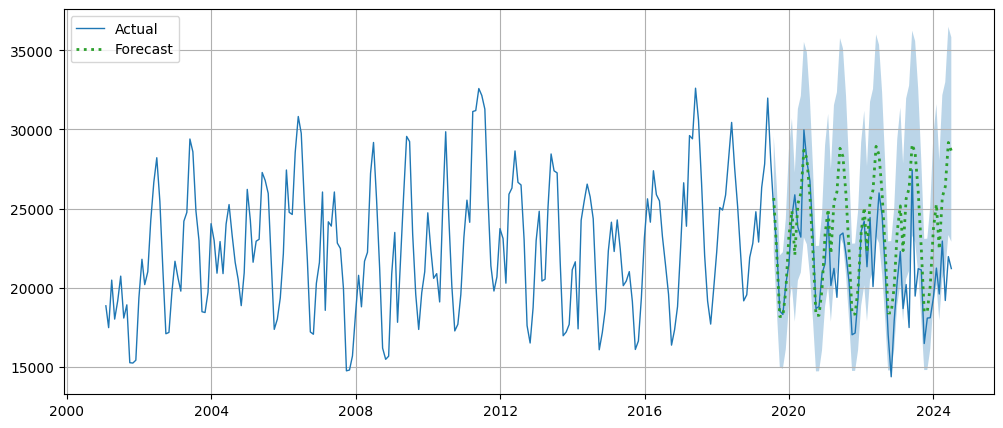

In [ ]:
plt.figure(figsize=(12,5))
plt.plot(hydro, label="Actual", **actual_options)
plt.plot(pred_mean, label="Forecast", **pred_options)
plt.fill_between(pred_ci.index, pred_ci.iloc[:,0], pred_ci.iloc[:,1], alpha=0.3)
plt.legend()
plt.grid()
plt.show()


In [ ]:
MAPE(pred_mean, test)


np.float64(13.017186152825715)